# ASTR 596: FDS Homework 7: Gaussian Processes
Name: Alex Gagliano

Due: 05/13/2020

### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


5203.7993840014005
5643.826820751147
5906.00942404101
5852.1877312730585


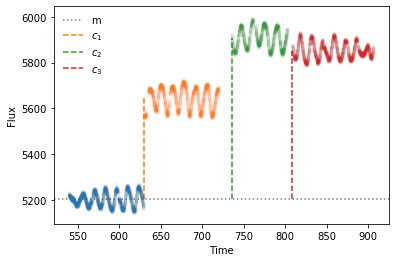

In [2]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    print(meanflux)
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False);

### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

Let's start off by defining a quasi-periodic kernel with the default george parameters. We'll get a bit of a sense for the priors for these values later on:

In [3]:
from george import kernels
from numpy import ma

gamma_init = 0.1 
logP_init = 5.0 
A_init = 10. 
lambda_init = 5.0 

kernel = kernels.ExpSine2Kernel(gamma=gamma_init, log_period=logP_init, ndim=1, axes=0)
kernel *= A_init * kernels.ExpSquaredKernel(metric=lambda_init, ndim=1, axes=0)

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

First, let's do a few housekeeping things: We'll write a loop to store the start and end times of each quarter as an array. Then, we'll subset our time and flux arrays in order to speed up our run.

In [4]:
# (I'm more used to pandas, so we'll use that)
global boundL, boundR
boundL = []
boundR = []
df = tab.to_pandas()
idxs = []
time_full = df['time'].values
flux_full = df['flux'].values
err_full = df['error'].values 

for i, q in enumerate(qs):
    ind = df[df['quarter']==q].index.values
    #get the times that each quarter begins, 
    #so that we can separate them out 
    boundL.append(time_full[ind[0]])
    boundR.append(time_full[ind[-1]])

#cut to make it easier to sample:
time = time_full[::10]
flux = flux_full[::10]
err = err_full[::10]

Next, let's construct a rough mean model: 

In [5]:
def mean_model(m, c1, c2, c3, t):
    var_arr = np.array([0, c1, c2, c3])
    soln = []
    for i in np.arange(4):
        tempMask = ma.masked_inside(time,boundL[i],boundR[i]).mask
        step = m*np.ones(len(time[tempMask])) + var_arr[i]
        len(step)
        soln = np.concatenate([soln, step])
    return soln

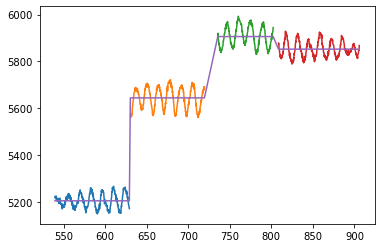

In [6]:
#estimates for our function parameters, based on the running means calculated earlier
m_est = means[0]
c1_est = means[1] - m_est
c2_est = means[2] - m_est
c3_est = means[3] - m_est

for i in np.arange(4):
    tempMask = ma.masked_inside(time,boundL[i],boundR[i]).mask
    plt.plot(time[tempMask], flux[tempMask])
model_data = mean_model(m_est, c1_est, c2_est, c3_est, time)
plt.plot(time, model_data, '-');

Hey, looks pretty good! We'll use this same basic structure for our mean model in george. We'll also add in our likelihood function:

In [7]:
import george
from george.modeling import Model

class StepModel(Model):
    parameter_names = ('m', 'c1', 'c2', 'c3')
    def get_parameter_vector(self):
        return np.array([self.m, self.c1, self.c2, self.c3])
    def set_vector(self, vec):
        self.m = vec[0]
        self.c1 = vec[1]
        self.c2 = vec[2]
        self.c3 = vec[3]
        #k.set_parameter_vector(k.get_parameter_vector() + np.random.randn(2))
    def set_parameter_vector(self, vec): 
        return set_vector(self, vec)
    def get_value(self, time):
        time = time.flatten()
        var_arr = np.array([0, self.c1, self.c2, self.c3])
        soln = []
        for i in np.arange(4):
            tempMask = ma.masked_inside(time,boundL[i],boundR[i]).mask
            step = self.m*np.ones(len(time[tempMask])) + var_arr[i]
            soln = np.concatenate([soln, step])
        return soln

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

We have our four initial guesses for our mean model from above: 

In [8]:
print("Our starting values: m = %.2f, c1 = %.2f, c2 = %.2f, c3 = %.2f.\n"%(m_est, c1_est, c2_est, c3_est))

Our starting values: m = 5203.80, c1 = 440.03, c2 = 702.21, c3 = 648.39.



To keep things simple, we'll make a flat prior for each parameter that contains the above estimates. By staring at the plot for a bit, we'll set the ranges of these flat priors as: 
$$ m \ \epsilon \ [5000, 5300] $$
$$ c_1 \ \epsilon \ [200, 600] $$
$$ c_2 \ \epsilon \ [600, 1000] $$
$$ c_3 \ \epsilon \ [400, 800] $$

To get reasonable priors for our kernel function, let's look at the kernel superimposed on our Quarter 6 data:

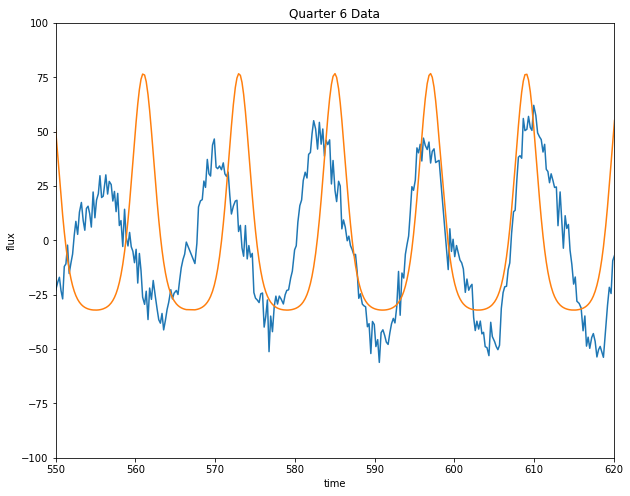

In [9]:
plt.figure(figsize=(10,8))
plt.plot(time, flux - means[0])
plt.ylim((-100, 100))
plt.xlim((550, 620))
plt.title("Quarter 6 Data")
plt.xlabel("time")
plt.ylabel("flux");
def kernel_fn(A, gamma, P, time, lamb):
    soln = A*np.exp(-gamma * np.sin(np.pi/P*np.abs(time)))
    return soln
gamma_init = 2 #
P_init = 6 #
A_init = 15 #
osc = kernel_fn(A_init, gamma_init, P_init, time, lambda_init)
plt.plot(time, osc-np.mean(osc));

okay so it's not perfect, but it's a start. Because we still don't know a ton about these parameters, let's set the ranges of the flat priors as follows:

$\Gamma \ \epsilon \ [-75, 75]$

$log(P) \ \epsilon \ [0, 30]$

$A \ \epsilon \ [0, 100]$

$\lambda  \ \epsilon \ [-10, 10]$ 

Okay, so we didn't plot the stationary kernel so we don't have a good range for $\lambda$, but we know because it's the scale factor that it can't be too large (but can be negative!)


In [10]:
def lnprob(p):
    #let's make them all flat priors - 
    lnp0 = lnp1 = lnp2 = lnp3 = 0
    logBoundL = np.array([5000, 200, 600, 400, -75, 0, 0, -10])
    logBoundR = np.array([5300, 600, 1000, 800, 75, 30, 100, 10])
    for i in np.arange(4):
        if (p[i] < logBoundL[i]) or (p[i] > logBoundR[i]):
            return -np.inf
    #for the other ones, make a wide prior for now.We'll edit later
    for i in [4, 5, 6, 7]:
        if ((p[i] < -100) or (p[i] > 100)):
            return -np.inf
    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    return gp.lnlikelihood(flux, quiet=True)

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

Before we use emcee, let's get better starting values for the parameters using scipy's optimize:

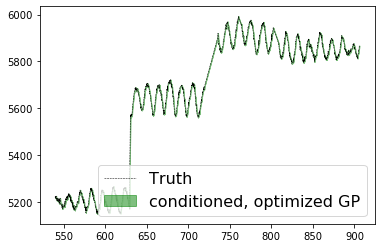

In [11]:
import scipy.optimize as op

gp = george.GP(mean=StepModel(m=m_est, c1=c1_est, c2=c2_est, c3=c3_est), kernel=kernel)

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(flux, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(flux, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(time)

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

ypred2, cov = gp.predict(flux, time, return_cov=True)
std = np.sqrt(np.diag(cov))

# plot the data
plt.fill_between(time, ypred2+std, ypred2-std, color="g", alpha=0.5, label='conditioned, optimized GP')

# and plot the truth
plt.plot(time, flux, 'k', ls='--', lw=0.5, label='Truth')
plt.legend(fontsize=16)

In [12]:
labels = ['m', 'c1', 'c2', 'c3', 'gamma', 'logP', 'A', 'lambda']
vals = results.x
print("Converged values:\n\n")
for i in np.arange(8):
    print("%s = %.2f\n" %(labels[i], vals[i]))

Converged values:


m = 5203.66

c1 = 439.77

c2 = 701.82

c3 = 648.59

gamma = 0.15

logP = 4.99

A = 6.79

lambda = -2.80



These will be fed into our gaussian process model below - we'll start each walker at a point perturbed from the values above.

In [13]:
import emcee

gp.compute(time)

# Set up the sampler.
nwalkers, ndim = 36, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = gp.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim)

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 200)

print("Running production chain")
sampler.run_mcmc(p0, 200);

Running burn-in
Running production chain


### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

Let's see how we did:

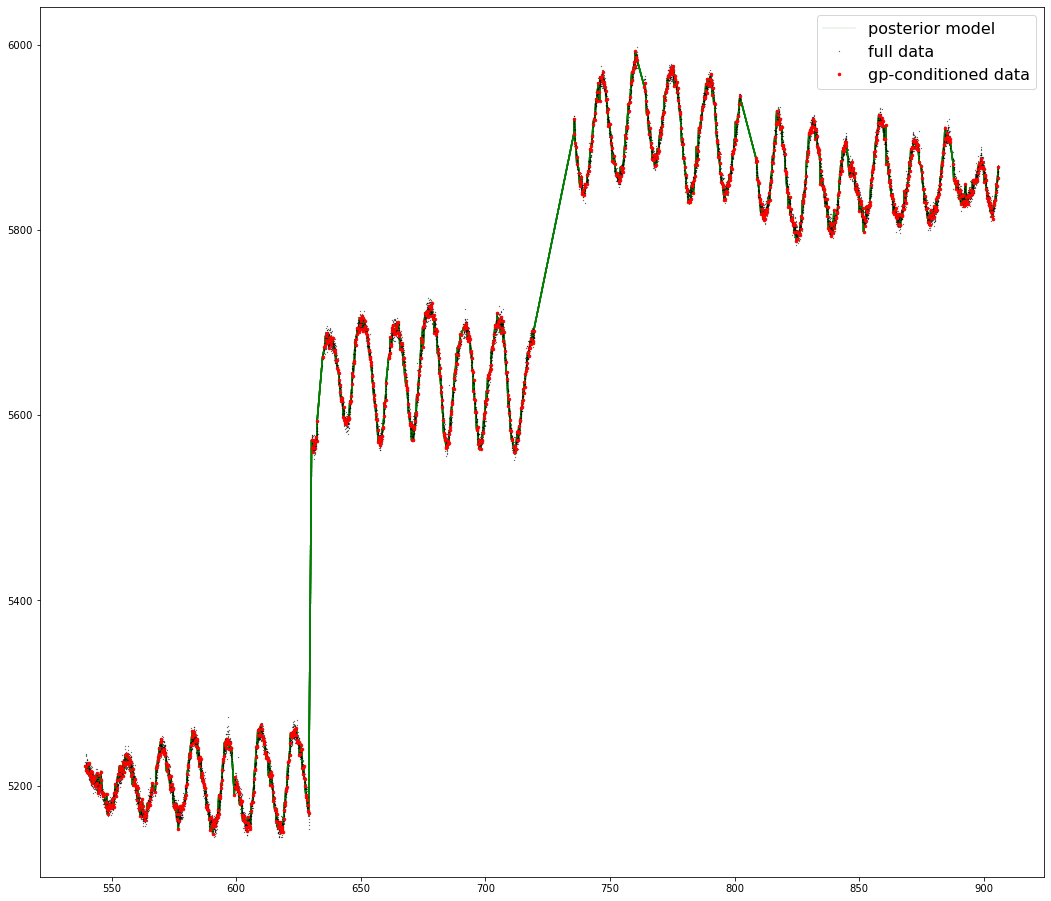

In [14]:
plt.figure(figsize=(18,16))
for i in range(50):
    # Choose a random walker and step.
    w = np.random.randint(sampler.chain.shape[0])
    n = np.random.randint(sampler.chain.shape[1])
    gp.set_parameter_vector(sampler.chain[w, n])

    # Plot a single sample.
    plt.plot(time, gp.sample_conditional(flux, time), "g", alpha=0.1)

#plot it one more time just to get a label in there 
plt.plot(time, gp.sample_conditional(flux, time), "g", alpha=0.1, label='posterior model')
plt.plot(time_full, flux_full, "k.", markersize=.5, label='full data')
plt.plot(time, flux, "r.", markersize=5, label='gp-conditioned data')
plt.legend(fontsize=16);

Beautiful! And, making a corner plot of our final values below (we'll also pretend our scipy optimized values are the "true", and see how they compare):

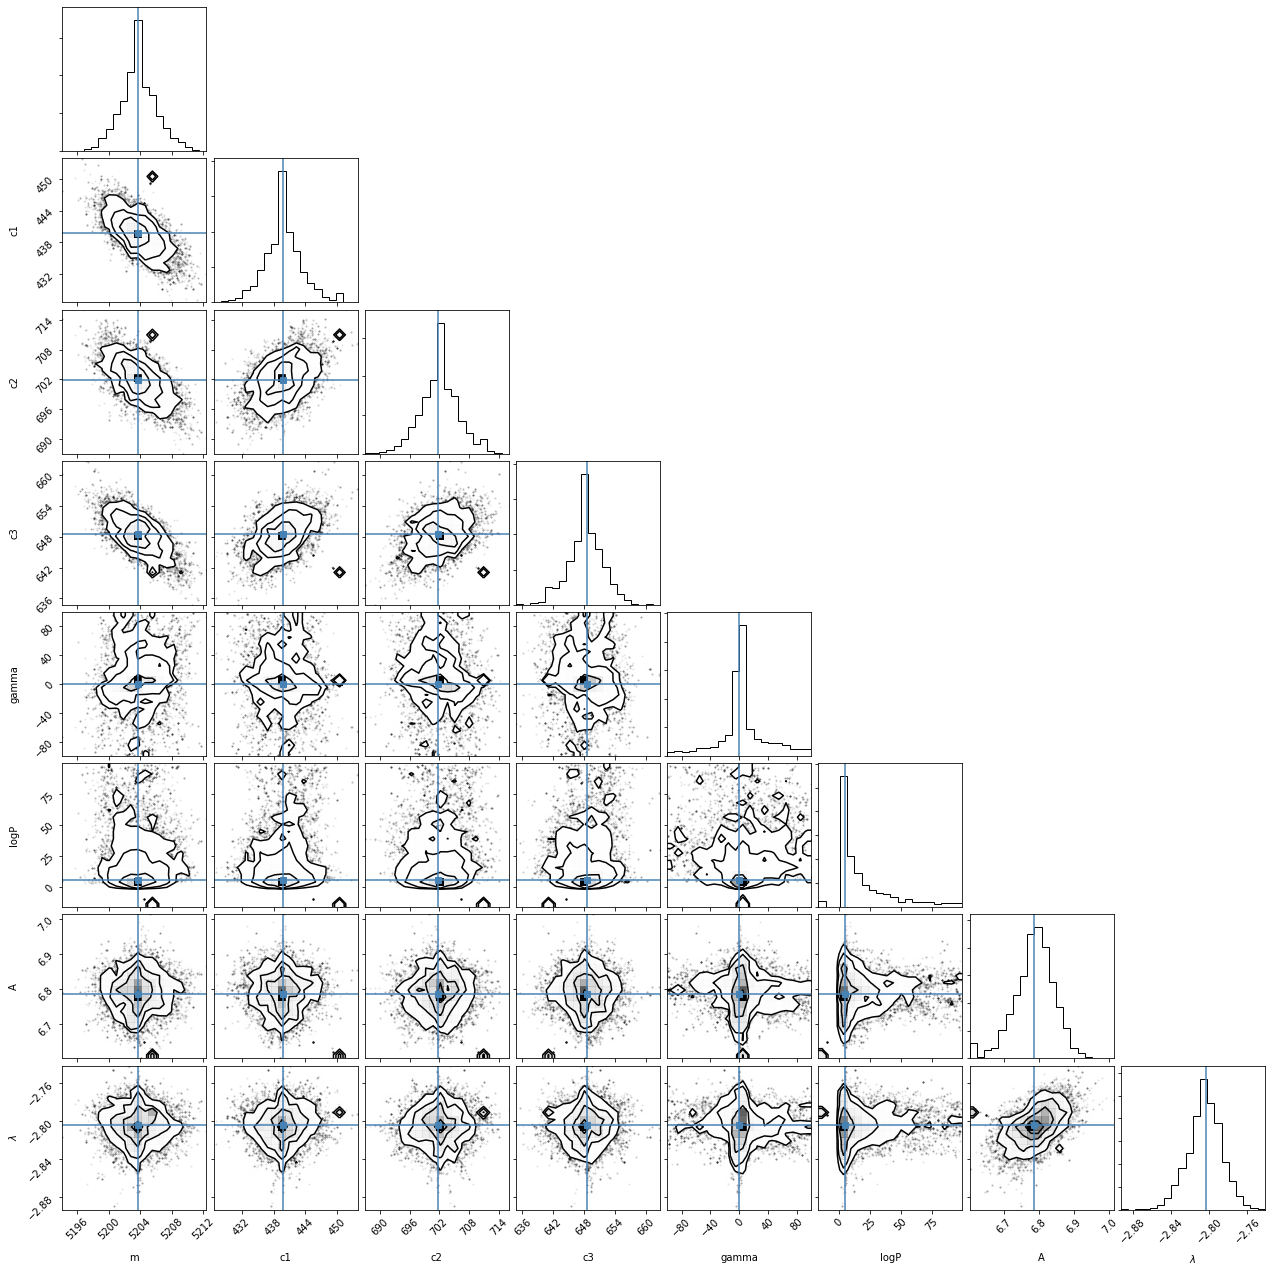

In [39]:
import corner

tri_labels = ['m', 'c1', 'c2', 'c3', 'gamma', 'logP', 'A', r'$\lambda$']
inds = np.arange(8)
true = results.x
corner.corner(sampler.flatchain[:, inds],  truths=true, labels=tri_labels);

Wow! It looks like our scipy-optimized values fall smack in the middle of our distributions. I'm fairly happy with that. Our chains look not great, but my guess is that with many more walkers for many more iterations (we only ran for 400 to keep runtimes reasonable) they'd narrow out again.  

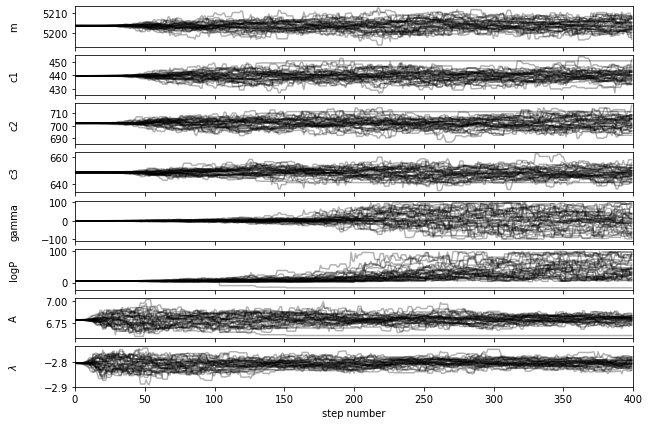

In [23]:
fig, axes = plt.subplots(8, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(tri_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");